#TS-CausalNN: Learning Temporal Causal Relations from Non-linear Non-stationary Time Series Data


This notebook contains the proposed TS-CausalNN model. Here we have developed the proposed Causal Conv2D layer and the optimization function.

The functions to visualize the predicted causal graph are available after the model training codes. The predicted graph is compared with ground truth using an adjacency matrix (array).   

In this notebook, we applied the proposed model to the synthetic dataset-1 to generate a full causal graph and summary graph.

In [1]:
import numpy as np
import pandas as pd

Upload the "synthetic_data_nonlinear_v3.csv" dataset from the "datasets" directory.

In [41]:
data = pd.read_csv('/content/synthetic_data_nonlinear_v3.csv')

In [34]:
data.iloc[0:5,:4]

,S1,S2,S3,S4
0,1.891355,0.000000,0.000000,0.000000
1,1.900402,0.864968,0.186294,9.985518
2,1.929503,0.220185,-0.037330,10.338397
3,1.776680,1.804606,-1.533456,12.602538
4,1.721463,4.807127,-2.538196,2.575272


In [16]:
true_graph = np.zeros((4,4))
true_graph[0,0]=1
true_graph[0,1]=1
true_graph[0,2]=1
true_graph[0,3]=1
true_graph[2,3]=1
true_graph[3,3]=1
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [17]:
true_full_graph = np.zeros((4,24))
true_full_graph[0,0]=1
true_full_graph[0,12]=1
true_full_graph[1,16]=1
true_full_graph[2,16]=1
true_full_graph[3,16]=1
true_full_graph[3,18]=1
true_full_graph[3,19]=1
true_full_graph


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0.]])

In [14]:
#Install this library to measure SHD

!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=4575015ac5197b2f6febee83aaca3569cc0287584c6f0b39afd3aed949ba41be
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=3dad52d3bca8fdfdfc33bb6962653cff76f29bcc6521fd17fe8197eb22b216bd
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [15]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#Data Pre-processing

In [35]:
import numpy as np
import pandas as pd

def data_preprocessing(data, max_lag=5):
  from sklearn.preprocessing import MinMaxScaler

  #convert to numpy array
  syn_data_np = data.to_numpy()

  #normalize the dataset
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  syn_data_np_nor = scaler_X.fit_transform(syn_data_np)
  syn_data_np = syn_data_np_nor

  #transform into 2D data
  syn_data_np_T= syn_data_np.T
  syn_data_pro = np.zeros((syn_data_np.shape[0]-max_lag,syn_data_np.shape[1],(max_lag+1)))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    syn_data_pro[i,:,:]= syn_data_np_T[:, i:i+(max_lag+1)]
  syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)

  #make datafrom with normalized data
  syn_data_nor_df =pd.DataFrame(data = syn_data_np,
                  columns = data.columns)

  #transform normalized data into 1D shape with lagged and current time values
  size_1d = syn_data_np.shape[1]*(max_lag+1)
  print(size_1d)
  syn_data_1d = np.zeros((syn_data_np.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np.shape[1]
      syn_data_1d[i,j_end:j_end+syn_data_np.shape[1]]= syn_data_np[i+j, :]

  #transform non-normalized data into 1D shape with lagged and current time values
  syn_data_np_2 = data.to_numpy()
  syn_data_1d_not_norm = np.zeros((syn_data_np_2.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np_2.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np_2.shape[1]
      syn_data_1d_not_norm[i,j_end:j_end+syn_data_np_2.shape[1]]= syn_data_np_2[i+j, :]


  return syn_data_np_nor, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm

In [42]:
syn_data_np, syn_data_2d, syn_data_nor_df, syn_data_1d, syn_data_1d_not_norm = data_preprocessing(data.iloc[:,:4], max_lag=5)

24


In [43]:
syn_data_2d.shape

(99995, 4, 6, 1)

In [44]:
syn_data_np.shape

(100000, 4)

In [45]:
syn_data_nor_df.shape

(100000, 4)

In [46]:
syn_data_1d.shape

(99995, 24)

In [47]:
syn_data_1d_not_norm.shape

(99995, 24)

In [48]:
syn_data_np.shape, syn_data_2d.shape

((100000, 4), (99995, 4, 6, 1))

In [49]:
data_y_syn = syn_data_np[5:,0:4]
data_y_syn.shape

(99995, 4)

# Proposed TS-CausalNN Model

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, Conv1D, AveragePooling1D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
import keras.backend as K
import tensorflow as tf
from keras.layers import concatenate
from keras.regularizers import l1, l2
from time import time

keras.utils.set_random_seed(1001)

In [ ]:
class CausalConv2D(tf.keras.layers.Layer):
    def __init__(self, num_outputs, counter, *args, **kwargs):
        super(CausalConv2D, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(*args, **kwargs)
        self.num_outputs = num_outputs
        self.counter = counter

    def build(self, input_shape):
        self.W=self.add_weight(name='kernel',
                           shape=(input_shape[1], input_shape[2],input_shape[3], 1),
                           #initializer = keras.initializers.RandomUniform(minval=0.05, maxval=0.5),
                           initializer = tf.keras.initializers.glorot_uniform(seed=8),
                           trainable=True)
        self.mask = np.ones(shape=self.W.shape)
        print(self.W)
        self.mask[self.counter,(input_shape[2]-1),...] = 0.0

    def get_weights(self):
        return super().get_weights()

    def call(self, inputs):
        self.W.assign(tf.math.multiply(self.W, self.mask))
        return self.conv2d.convolution_op(inputs, self.W)

In [ ]:
def get_model_2d(input_dims):
    input_batch = Input(shape = input_dims)

    conv_model = Sequential()
    conv_model = Conv2D(filters=4, kernel_size=1, strides=(1,1), padding='valid', activation="linear", name='conv1')(input_batch)
    conv_model = tf.math.reduce_mean(conv_model, axis=-1)
    conv_model = Reshape((4, 6, 1))(conv_model)
    pooled_outputs = []
    for i in range(0, 4):
      layer = CausalConv2D(filters=1, kernel_size=(4,6), num_outputs=1, counter=i, padding='valid', activation="tanh",)(conv_model)
      pooled_outputs.append(layer)
    output = concatenate(pooled_outputs)
    output = Flatten()(output)

    model = Model(inputs=input_batch, outputs=output, name='cpred')

    return model

In [ ]:
class CausalNNModel(object):
    def __init__(self,
                 dims,
                 alpha=0.0,
                 rho = 1.0,
                 rho_max = 10e20,
                 h_tol = 1e-8,
                 init='glorot_uniform'):

        super(CausalNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1
        self.alpha = alpha
        self.rho = rho
        self.h_p = np.Inf
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_2d = get_model_2d(self.dims)
        print("====Model created=====")

        self.model = Model(inputs=self.model_2d.input, outputs=self.model_2d.output)


    def custom_loss_function(self, y_true, y_pred):
      mse = keras.losses.mean_squared_error(y_true, y_pred)
      h_val = self.causal_loss_h()
      h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
      lambda1 = 0.1
      adj_mat = self.get_mat()
      sparse_loss = lambda1 * tf.math.reduce_sum(tf.abs(adj_mat))
      print('MSE Loss is: {}, h Loss is: {}, L1 loss: {}, Total Loss is: {}'.format(tf.reduce_mean(mse), h_loss, sparse_loss, tf.reduce_mean(mse)+h_loss))
      return mse + h_loss + sparse_loss

    def causal_loss_h(self):
      mat = self.get_mat()
      h_val = self.h_acy_1(mat[:, 20:])
      return h_val

    def get_mat(self):
      w1_2d_s = self.model.get_layer(index=-6).get_weights()
      w2_2d_s = self.model.get_layer(index=-5).get_weights()
      w3_2d_s = self.model.get_layer(index=-4).get_weights()
      w4_2d_s = self.model.get_layer(index=-3).get_weights()
      arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr2_2d_s = np.expand_dims(np.squeeze(np.array(w2_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr3_2d_s = np.expand_dims(np.squeeze(np.array(w3_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr4_2d_s = np.expand_dims(np.squeeze(np.array(w4_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      mat_2d_s = np.concatenate((arr1_2d_s, arr2_2d_s, arr3_2d_s, arr4_2d_s))
      #print(mat_2d_s)
      return mat_2d_s

    def h_acy_1(self, A):
      n_var = A.shape[0]
      h = tf.linalg.trace(tf.linalg.expm(A * A)) - n_var
      return h


    def h_acy(self, A):
      '''Calculate the constraint of A ensure that it's a DAG'''
      n_var = A.shape[0]
      M = tf.eye(n_var, num_columns = n_var) + A/n_var
      E = M
      for _ in range(n_var - 2):
        E = tf.linalg.matmul(E, M)
      h = tf.math.reduce_sum(tf.transpose(E) * M) - n_var
      return h

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss= self.custom_loss_function) # ['mse', self.causal_loss()])

    def fit(self, x, y=None, maxiter=100, batch_size=512, save_dir='./results/temp'):
        t1 = time()

        # logging file
        import csv
        logfile = open(save_dir + '/causalnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()
        train_loader = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        optimizer = tf.keras.optimizers.Adam(1e-2)
        w1_2d_s = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)


        for epoch in range(int(maxiter)):
          print('Epoch: {}', epoch)
          h_n = None
          for (x, y) in train_loader:
            #eval loss and compute gradients
            with tf.GradientTape() as tape:
              tape.watch(self.model.trainable_variables)
              #passing through neural network
              output = self.model(x)
              #calculate loss
              loss = self.custom_loss_function(y, output)
              gradients = tape.gradient(loss, self.model.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
              h_n = self.causal_loss_h()

          if h_n > 0.25 * self.h_p:
                self.rho = self.rho*1.1
          self.h_p = h_n
          print('New h_val is :', h_n)
          self.alpha += self.rho * self.h_p

          if self.h_p <= self.h_tol or self.rho >= self.rho_max:
            print('Before the loop end # h_val is: {}, rho is: {}'.format(self.h_p, self.rho))
            break

        #for ite in range(int(maxiter)):
        #  print('Epoch: {}', ite)
        #  self.model.fit(x, y, epochs=1, batch_size=batch_size, verbose=True)

        # save the trained model
        logfile.close()
        file_name  = "/CausalNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        w1_2d_s_1 = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s_1 = np.expand_dims(np.squeeze(np.array(w1_2d_s_1), axis=(0,3,4)).flatten('F'), axis=0)

        y_pred = self.model.predict(x)
        adj_mat = self.get_mat()

        print('The conv layer 1 weights before training :', arr1_2d_s)
        print('The conv layer 1 weights after training :', arr1_2d_s_1)

        return y_pred, adj_mat

#Model creation and training:

In [ ]:
keras.utils.set_random_seed(1001)

cnnmodel = CausalNNModel(dims=syn_data_2d.shape[1:])

<tf.Variable 'causal_conv2d_4/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

        [[ 0.34967968]],

        [[-0.22822307]],

        [[ 0.18624505]],

        [[-0.03919902]],

        [[-0.03960952]]],


       [[[ 0.20739552]],

        [[-0.14644605]],

        [[ 0.21469983]],

        [[-0.17902574]],

        [[ 0.06509387]],

        [[ 0.17076865]]],


       [[[ 0.21393666]],

        [[-0.3412853 ]],

        [[ 0.0880048 ]],

        [[-0.3153036 ]],

        [[-0.07369781]],

        [[ 0.15640828]]]], dtype=float32)>
<tf.Variable 'causal_conv2d_5/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

       

In [ ]:
cnnmodel.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4, 6, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 4, 6, 4)              8         ['input_2[0][0]']             
                                                                                                  
 tf.math.reduce_mean_1 (TFO  (None, 4, 6)                 0         ['conv1[0][0]']               
 pLambda)                                                                                         
                                                                                                  
 reshape_1 (Reshape)         (None, 4, 6, 1)              0         ['tf.math.reduce_mean_1[

In [ ]:
cnnmodel.compile()

In [ ]:
y_pred, mat = cnnmodel.fit(x=syn_data_2d, y=data_y_syn, maxiter=25, batch_size=2048, save_dir='/content/')

Epoch: {} 0
MSE Loss is: 0.26760026812553406, h Loss is: 1.003495640361507e-06, L1 loss: 1.4565690755844116, Total Loss is: 0.26760128140449524
MSE Loss is: 0.2552680969238281, h Loss is: 1.1561634210011107e-06, L1 loss: 1.4485690593719482, Total Loss is: 0.25526925921440125
MSE Loss is: 0.2450333684682846, h Loss is: 1.3688918443222065e-06, L1 loss: 1.4407037496566772, Total Loss is: 0.24503473937511444
MSE Loss is: 0.24168989062309265, h Loss is: 1.6563591316298698e-06, L1 loss: 1.4330939054489136, Total Loss is: 0.24169154465198517
MSE Loss is: 0.23534904420375824, h Loss is: 2.0418888198037166e-06, L1 loss: 1.4307199716567993, Total Loss is: 0.2353510856628418
MSE Loss is: 0.2230149805545807, h Loss is: 2.5683002604637295e-06, L1 loss: 1.4427626132965088, Total Loss is: 0.22301754355430603
MSE Loss is: 0.20996740460395813, h Loss is: 3.3126530070148874e-06, L1 loss: 1.4558145999908447, Total Loss is: 0.20997071266174316
MSE Loss is: 0.18882450461387634, h Loss is: 4.387055014376528

Convert the predicted adjacency for visualization as a table.

In [3]:
mat_df_2d_s = pd.DataFrame(mat)

In [4]:
mat_f_df = pd.DataFrame(mat).T

In [5]:
mat_df_2d_s.T

,0,1,2,3
0,0.124722,-0.103244,0.308313,-0.079268
1,-0.105211,0.291369,-0.158405,-0.090237
2,0.131954,0.297862,-0.049715,0.070652
3,-0.488709,0.100331,-0.078347,-0.048234
4,0.433671,0.093865,-0.042242,0.029934
5,-0.043210,0.205144,-0.019079,-0.035819
6,0.038459,-0.034324,0.004635,-0.049715
7,-0.084535,-0.187699,0.106580,0.003939
8,0.279563,-0.105189,0.238387,-0.078160
9,-0.048708,0.187708,0.059846,-0.109191


#Full Causal Graph

In [6]:
matrix = mat

In [ ]:
np.savetxt('proposed-full-adj-mat_syn_V2_n.csv', matrix, delimiter=",")

In [7]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
pred_graph_f = np.zeros((4,24))

In [8]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [9]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix[j,i] > 0.3:
      print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)
      pred_graph_f[j,i]=1


0 2
4 0
12 0
12 3
16 0
16 1
16 2
18 3
22 3
23 2


In [10]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
pos_2d_s

{'S1(t-5)': (1, 1),
 'S2(t-5)': (1, 2),
 'S3(t-5)': (1, 3),
 'S4(t-5)': (1, 4),
 'S1(t-4)': (2, 1),
 'S2(t-4)': (2, 2),
 'S3(t-4)': (2, 3),
 'S4(t-4)': (2, 4),
 'S1(t-3)': (3, 1),
 'S2(t-3)': (3, 2),
 'S3(t-3)': (3, 3),
 'S4(t-3)': (3, 4),
 'S1(t-2)': (4, 1),
 'S2(t-2)': (4, 2),
 'S3(t-2)': (4, 3),
 'S4(t-2)': (4, 4),
 'S1(t-1)': (5, 1),
 'S2(t-1)': (5, 2),
 'S3(t-1)': (5, 3),
 'S4(t-1)': (5, 4),
 'S1(t)': (6, 1),
 'S2(t)': (6, 2),
 'S3(t)': (6, 3),
 'S4(t)': (6, 4)}

In [11]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

##Plotting the predicted full temporal causal graph.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


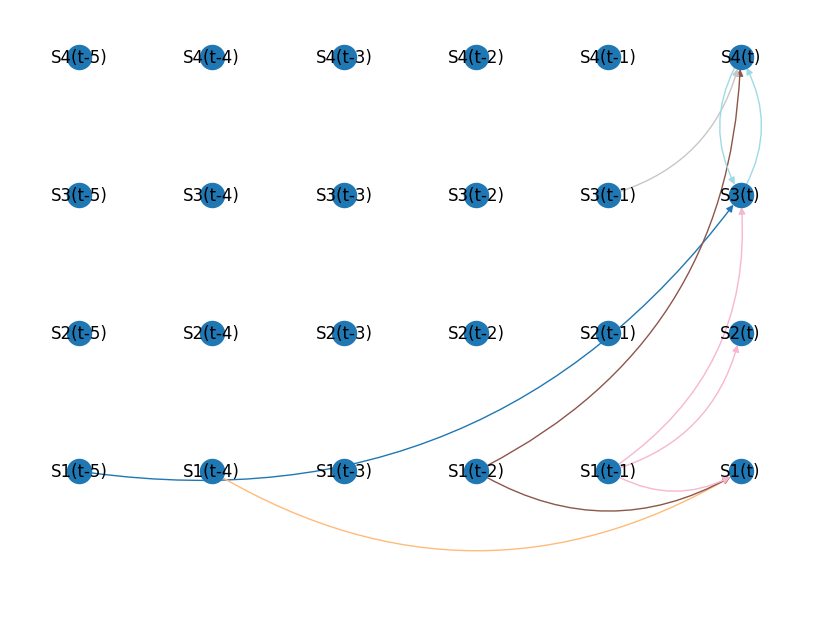

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [13]:
pred_graph_f

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0.]])

Calculate the SHD for full temporal causal graph.

In [18]:
cdt.metrics.SHD(true_full_graph, pred_graph_f)

9.0

In [19]:
true_values = true_full_graph
predictions = pred_graph_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.90625, Precision: 0.4, Recall: 0.5714285714285714, FDR: 0.6, F1 Score: 0.47058823529411764


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.90625
Precision: 0.4
Recall (Sensitivity): 0.5714285714285714
F1-Score: 0.47058823529411764


#Summary Causal Graph

In [21]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [22]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [23]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix[j,i] > 0.3:
      print(i,j)
      col = np.round(matrix[j,i], 2)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=col)
      pred_graph_s1[i%4, j]=1


0 2
4 0
12 0
12 3
16 0
16 1
16 2
18 3
22 3
23 2


In [24]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [25]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


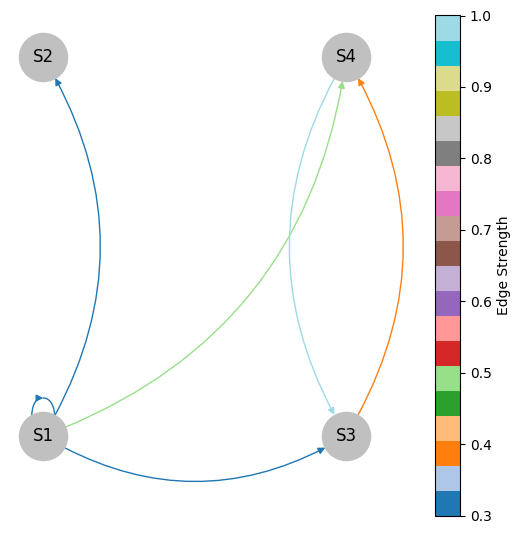

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.3, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [27]:
pred_graph_s1

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [28]:
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
np.savetxt('proposed-summary-adj-mat.csv', pred_graph_s1, delimiter=",")

In [29]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

2.0

In [30]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.875, Precision: 0.8333333333333334, Recall: 0.8333333333333334, FDR: 0.16666666666666666, F1 Score: 0.8333333333333334


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.875
Precision: 0.8333333333333334
Recall (Sensitivity): 0.8333333333333334
F1-Score: 0.8333333333333334
